In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = ''
from tqdm import tqdm
sys.path.append(os.path.abspath('..'))
import modules.io as io
import modules.vascular_data as sv
from medpy.metric.binary import dc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import tensorflow as tf

In [2]:
DATA_KEY    = "VAL"
CONFIG_FILE = '../config/uq/googlenet_c30_train300k_aug10_clean_uq3.yaml'
#CONFIG_FILE = '../config/unet_c30_train300k_aug10_clean.yaml'
LOAD = True

config      = io.load_yaml(CONFIG_FILE)
config['MODEL_DIR'] = config['MODEL_DIR'].replace('.','..')
#config['DROPOUT'] = 0.1

DROP = str(config['DROPOUT'])

SCALE = config['CROP_DIMS']/2*config['SPACING']

In [3]:
import factories.dataset_factory as dataset_factory

data    = dataset_factory.get(config, DATA_KEY)

231it [00:00, 3895.80it/s]
  0%|          | 0/231 [00:00<?, ?it/s]

centering images


100%|██████████| 231/231 [00:02<00:00, 90.75it/s]


In [4]:
import factories.model_factory as model_factory

model = model_factory.get(config)
if LOAD: model.load()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




pool 1 Tensor("googlenet/max_pool:0", shape=(?, 79, 79, 64), dtype=float32)
pool_2 Tensor("googlenet/max_pool_1:0", shape=(?, 39, 39, 192), dtype=float32)
pool 3 Tensor("googlenet/max_pool_2:0", shape=(?, 19, 19, 480), dtype=float32)
pool side Tensor("googlenet/avg_pool:0", shape=(?, 5, 5, 833), dtype=float32)
[None, 3200]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[None, 1024]
pool 5 Tensor("googlenet/max_pool_3:0", shape=(?, 9, 9, 833), dtype=float32)
pool final Tensor("googlenet/avg_pool_1:0", shape=(?, 3, 3, 1024), dtype=float32)
[None, 9216]
[None, 

In [5]:
tensor_list = [n.name for n in tf.get_default_graph().as_graph_def().node]
for t in tensor_list:
    print(t)

Placeholder
Placeholder_1
googlenet/input_7x7/random_normal/shape
googlenet/input_7x7/random_normal/mean
googlenet/input_7x7/random_normal/stddev
googlenet/input_7x7/random_normal/RandomStandardNormal
googlenet/input_7x7/random_normal/mul
googlenet/input_7x7/random_normal
googlenet/input_7x7/W
googlenet/input_7x7/W/Assign
googlenet/input_7x7/W/read
googlenet/input_7x7/zeros
googlenet/input_7x7/b
googlenet/input_7x7/b/Assign
googlenet/input_7x7/b/read
googlenet/input_7x7/convolution
googlenet/input_7x7/add
googlenet/input_7x7/leaky_re_lu/LeakyRelu
googlenet/max_pool/dilation_rate
googlenet/max_pool
googlenet/input_1x1_r/random_normal/shape
googlenet/input_1x1_r/random_normal/mean
googlenet/input_1x1_r/random_normal/stddev
googlenet/input_1x1_r/random_normal/RandomStandardNormal
googlenet/input_1x1_r/random_normal/mul
googlenet/input_1x1_r/random_normal
googlenet/input_1x1_r/W
googlenet/input_1x1_r/W/Assign
googlenet/input_1x1_r/W/read
googlenet/input_1x1_r/zeros
googlenet/input_1x1_r/b


gradients/googlenet/inception_4a/5x5_reduce/add_grad/Shape
gradients/googlenet/inception_4a/5x5_reduce/add_grad/Shape_1
gradients/googlenet/inception_4a/5x5_reduce/add_grad/BroadcastGradientArgs
gradients/googlenet/inception_4a/5x5_reduce/add_grad/Sum
gradients/googlenet/inception_4a/5x5_reduce/add_grad/Reshape
gradients/googlenet/inception_4a/5x5_reduce/add_grad/Sum_1
gradients/googlenet/inception_4a/5x5_reduce/add_grad/Reshape_1
gradients/googlenet/inception_4a/5x5_reduce/add_grad/tuple/group_deps
gradients/googlenet/inception_4a/5x5_reduce/add_grad/tuple/control_dependency
gradients/googlenet/inception_4a/5x5_reduce/add_grad/tuple/control_dependency_1
gradients/googlenet/inception_4a/3x3_reduce/convolution_grad/ShapeN
gradients/googlenet/inception_4a/3x3_reduce/convolution_grad/Conv2DBackpropInput
gradients/googlenet/inception_4a/3x3_reduce/convolution_grad/Conv2DBackpropFilter
gradients/googlenet/inception_4a/3x3_reduce/convolution_grad/tuple/group_deps
gradients/googlenet/inceptio

In [6]:
import factories.preprocessor_factory as prepro_factory

preprocessor = prepro_factory.get(config)

In [7]:
import factories.postprocessor_factory as postpro_factory

postprocessor = postpro_factory.get(config)

In [8]:
X = np.array([preprocessor(x) for x in data[0]])
print(X.shape)

(231, 160, 160, 1)


In [9]:
op = tf.get_default_graph().get_tensor_by_name("googlenet/dropout/random_uniform:0")
print(op)

Tensor("googlenet/dropout/random_uniform:0", shape=(?, 1024), dtype=float32)


In [10]:
out = model.sess.run(op, {model.x:X[0][np.newaxis,:,:,:]})
print(out.shape)
print(out[:10])

(1, 1024)
[[0.9497285  0.5664741  0.4851296  ... 0.8656235  0.77784073 0.3587346 ]]


In [11]:
INDEX = 1
N = 40
#model.sample()
contours = []
for i in range(N):
    yhat = model.predict(X[INDEX])
    c    = postprocessor(yhat)
    contours.append(c)

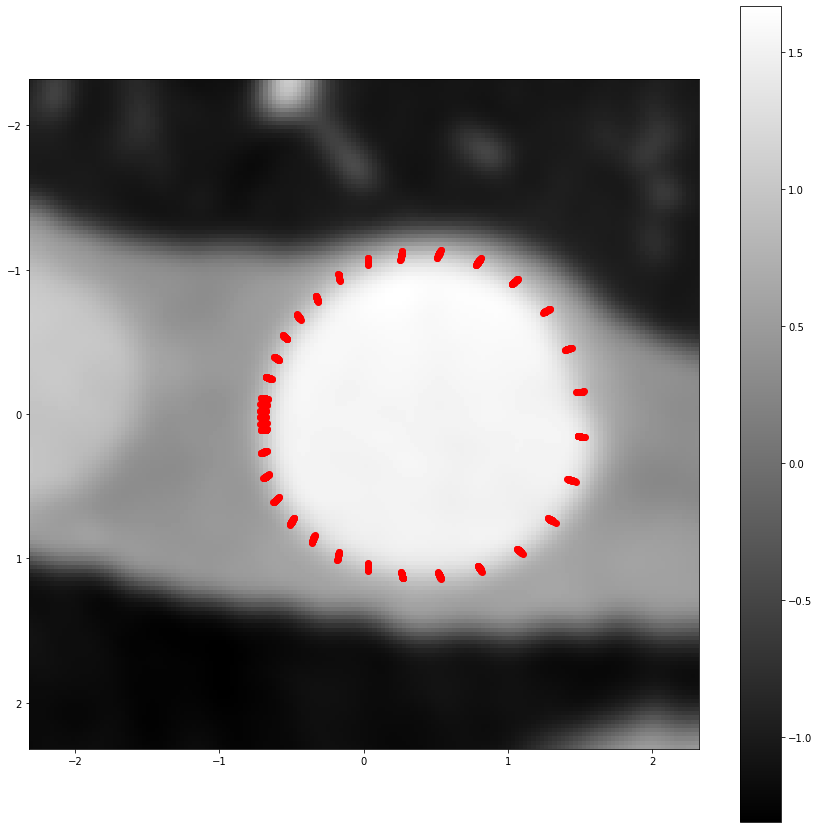

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(X[INDEX,:,:,0], extent=[-SCALE, SCALE, SCALE, -SCALE], cmap='gray')
for c in contours:
    plt.plot(c[:,0], c[:,1], color='r', marker='o', linestyle='')
plt.colorbar()
plt.show()

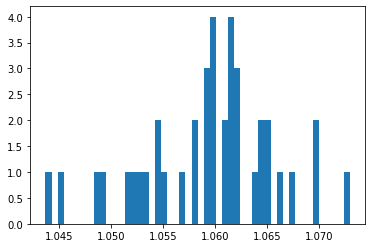

In [13]:
radiuses = []
for c in contours:
    cc = c-np.mean(c,axis=0)
    rs = np.sqrt(np.sum(cc**2,axis=1))
    r  = np.mean(rs)
    radiuses.append(r)

plt.figure()
plt.hist(radiuses, bins=50, label='radius')
plt.show()

In [14]:
Nx = X.shape[0]
Nc = 100
C  = np.zeros((Nx,Nc,34,2))

In [15]:
for i in tqdm(range(X.shape[0])):
    for j in range(Nc):
        yhat = model.predict(X[i])
        c    = postprocessor(yhat)
    
        cc = c-np.mean(c,axis=0)
        C[i,j] = cc

100%|██████████| 231/231 [06:52<00:00,  1.78s/it]


In [16]:
Cbar = np.mean(C,axis=1)

In [17]:
W = 160
SPACING = 0.029
ORIGIN = 0

dice = []
rads = []

for i in range(Nx):
    ct = Cbar[i]
    for j in range(Nc):
        c = C[i,j]


        seg   = sv.contourToSeg(c,[ORIGIN]*2,[W]*2,[SPACING]*2)
        seg_t = sv.contourToSeg(ct,[ORIGIN]*2,[W]*2,[SPACING]*2)

        r = np.sqrt(np.sum(seg)*1.0/np.pi)*SPACING
        d = dc(seg,seg_t)

        rads.append(r)
        dice.append(d)

rads = np.array(rads)
dice = np.array(dice)

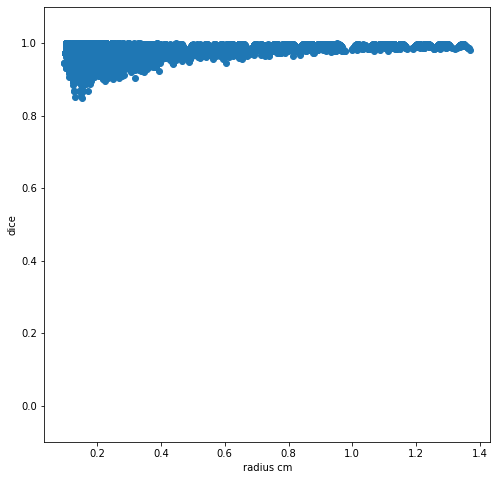

In [18]:
plt.figure(figsize=(8,8))
plt.plot(rads,dice,marker='o',linestyle='')
plt.xlabel('radius cm')
plt.ylabel('dice')
plt.ylim(-0.1,1.1)
plt.savefig('drop_{}.png'.format(DROP), dpi=300)
plt.savefig('drop_{}.pdf'.format(DROP), dpi=300)
plt.show()

In [19]:
W = 160
SPACING = 0.029
ORIGIN = 0

dice = []
rads = []
rads_diff = []
for i in tqdm(range(Nx)):
    ct = Cbar[i]
    for j in range(Nc):
        
        dd = []
        rr = []
        
        c = C[i,j]
        seg   = sv.contourToSeg(c,[ORIGIN]*2,[W]*2,[SPACING]*2)
        
        for k in range(Nc):    
            c2 = C[i,k]
            seg_t = sv.contourToSeg(c2,[ORIGIN]*2,[W]*2,[SPACING]*2)

            r = np.sqrt(np.sum(seg)*1.0/np.pi)*SPACING
            d = dc(seg,seg_t)

            rr.append(r)
            dd.append(d)
            
        rads.append(np.mean(rr))
        rads_diff.append(np.amax(np.abs(np.array(rr)-np.mean(rr))))
        dice.append(np.amin(dd))

rads = np.array(rads)
dice = np.array(dice)

 35%|███▍      | 80/231 [16:35<31:02, 12.34s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/marsdenlab/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-8d9c96343c28>", line 23, in <module>
    d = dc(seg,seg_t)
  File "/home/marsdenlab/anaconda3/lib/python3.7/site-packages/medpy/metric/binary.py", line 71, in dc
    intersection = numpy.count_nonzero(result & reference)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marsdenlab/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2018, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marsdenlab/anaconda3/lib/python3.7/site-packages/IPython/

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(rads,dice,marker='o',linestyle='')
plt.xlabel('radius cm')
plt.ylabel('dice')
plt.ylim(-0.1,1.1)
plt.savefig('drop_{}.png'.format(DROP), dpi=300)
plt.savefig('drop_{}.pdf'.format(DROP), dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(rads,rads_diff,marker='o',linestyle='')
plt.xlabel('radius cm')
plt.ylabel('dice')
plt.ylim(-0.1,1.1)
plt.savefig('drop_{}.png'.format(DROP), dpi=300)
plt.savefig('drop_{}.pdf'.format(DROP), dpi=300)
plt.show()

In [ ]:
inds = rads < 0.4
ds = dice[inds]
print(np.mean(ds))
print(np.std(ds))

In [ ]:
inds = rads > 0.4
ds = dice[inds]
print(np.mean(ds))
print(np.std(ds))